In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
import random
import tensorflowjs as tfjs
from tensorflow.keras.preprocessing.image import ImageDataGenerator


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
def compute_statistics(paths):
    widths = []
    heights = []
    ratios = []
    for i, p in enumerate(paths):
        image_raw = tf.io.read_file(p)
        image = tf.io.decode_png(image_raw)
        shape = image.shape
        widths.append(shape[1])
        heights.append(shape[0])
        ratios.append(float(shape[1]) / shape[0])
        print('\rread %d/%d' % (i, len(paths)), end='')
        del image
    print()
    return widths, heights, ratios


train_images = glob('./chest_xray/train/NORMAL/*.jpeg') + glob('./chest_xray/train/PNEUMONIA/*.jpeg')
widths, heights, ratios = compute_statistics(train_images)

read 5215/5216


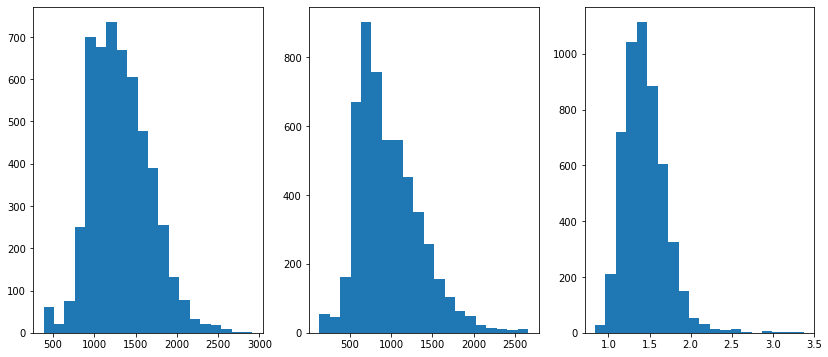

mean widths:  1320.6108128834355
mean heights:  968.0747699386503
mean ratios 1.440235837086363


In [3]:
def plot_statistics(widths, heights, ratios, bins=20):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 3, 1)
    plt.hist(widths, bins=bins)
    plt.subplot(1, 3, 2)
    plt.hist(heights, bins=bins)
    plt.subplot(1, 3, 3)
    plt.hist(ratios, bins=bins)
    plt.show()
    
    print('mean widths: ', np.mean(widths))
    print('mean heights: ', np.mean(heights))
    print('mean ratios', np.mean(ratios))


plot_statistics(widths, heights, ratios)

In [4]:
test_images = glob('./chest_xray/test/NORMAL/*.jpeg') + glob('./chest_xray/test/PNEUMONIA/*.jpeg')
test_widths, test_heights, test_ratios = compute_statistics(test_images)

read 623/624


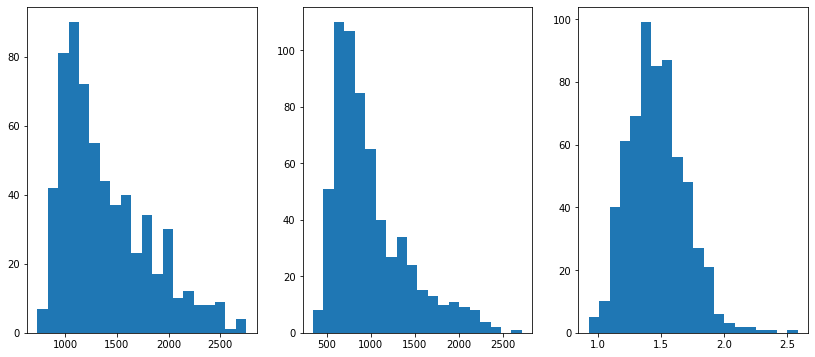

mean widths:  1388.128205128205
mean heights:  991.7147435897435
mean ratios 1.4676276770555472


In [5]:
plot_statistics(test_widths, test_heights, test_ratios)

In [6]:
INPUT_SIZE = (256, 256)


def shuffle(image_paths, labels):
    pairs = [(image_paths[i], labels[i]) for i in range(len(image_paths))]
    random.shuffle(pairs)
    image_paths = [p[0] for p in pairs]
    labels = [p[1] for p in pairs]
    return image_paths, labels


def load_data(name, balancing=False):
    positives = glob('./chest_xray/%s/PNEUMONIA/*.jpeg' % (name))
    negatives = glob('./chest_xray/%s/NORMAL/*.jpeg' % (name))
    
    print('positives: ', len(positives))
    print('negatives: ', len(negatives))
    
    if balancing:
        if len(positives) < len(negatives):
            n = len(positives)
            while len(positives) < len(negatives):
                idx = np.random.randint(0, n)
                positives.append(positives[idx])
        elif len(positives) > len(negatives):
            n = len(negatives)
            while len(negatives) < len(positives):
                idx = np.random.randint(0, n)
                negatives.append(negatives[idx])

        print('after balancing...')
        print('positives: ', len(positives))
        print('negatives: ', len(negatives))
    
    p_labels = [1 for _ in positives]
    n_labels = [0 for _ in negatives]
    
    image_paths = positives + negatives
    labels = p_labels + n_labels
    assert len(positives) > 0
    assert len(negatives) > 0
    assert len(image_paths) == len(labels)
    
    image_paths, labels = shuffle(image_paths, labels)
    
    images = []
    for p in image_paths:
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, INPUT_SIZE)
        images.append(img)
        
    assert len(images) == len(labels)
    return images, labels


train_images, train_labels = load_data('train')
val_images, val_labels = load_data('val')
test_images, test_labels = load_data('test')

print('train images: ', len(train_images))
print('val images: ', len(val_images))
print('test images: ', len(test_images))

positives:  3875
negatives:  1341
positives:  8
negatives:  8
positives:  390
negatives:  234
train images:  5216
val images:  16
test images:  624


(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


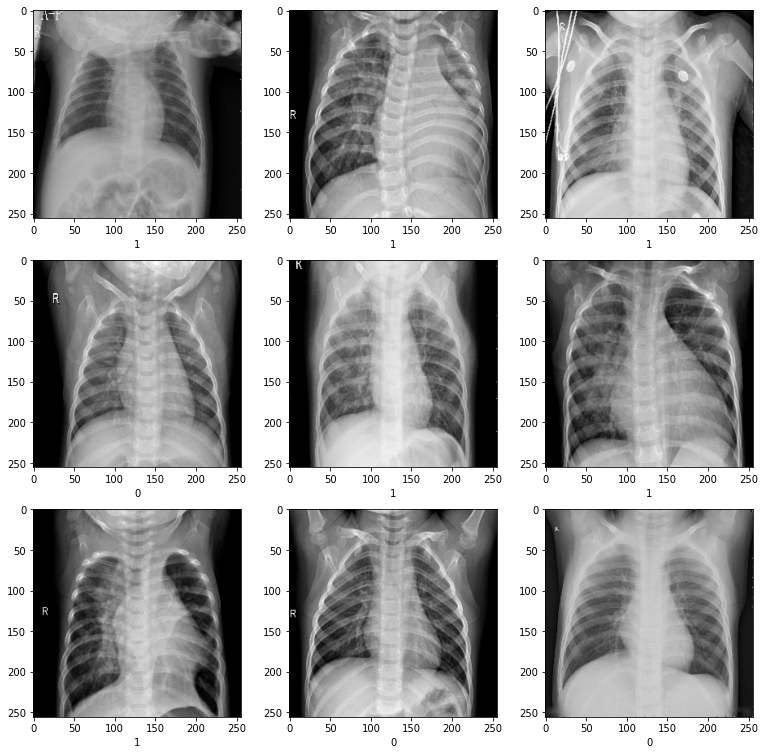

In [7]:
plt.figure(figsize=(13, 13))
for i in range(9):
    idx = np.random.randint(0, len(train_images))
    plt.subplot(3, 3, i+1)
    plt.imshow(train_images[idx], cmap='gray')
    plt.xlabel(str(train_labels[idx]))
    print(train_images[idx].shape)
plt.show()

(5216, 256, 256, 1)
(624, 256, 256, 1)


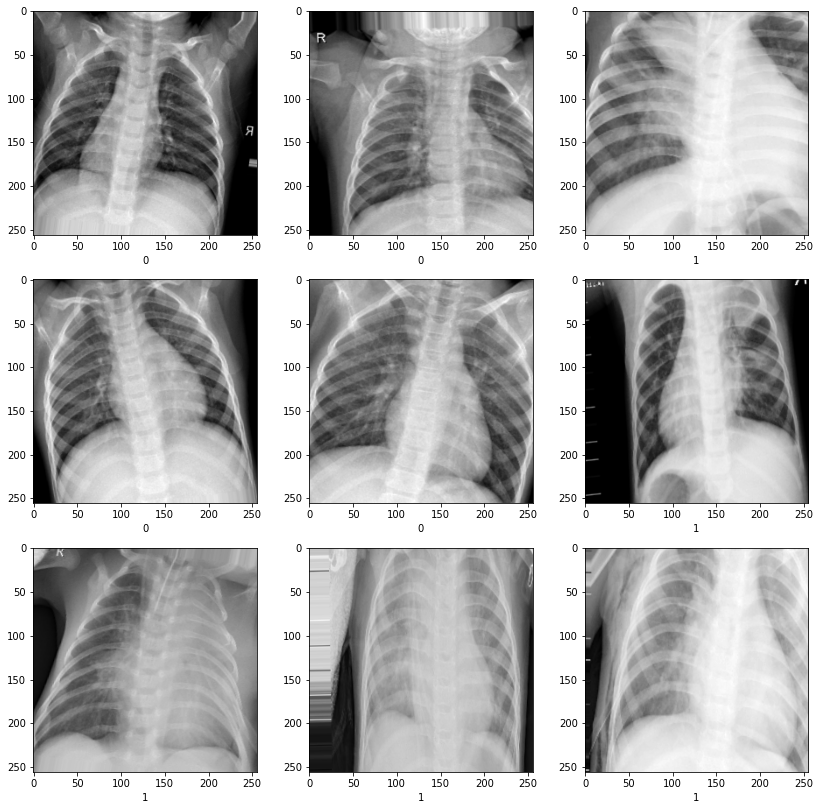

In [8]:
BATCH_SIZE = 16

train_gen = ImageDataGenerator(rotation_range=10,
                               horizontal_flip=True,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rescale=1.0/255,
                               zoom_range=[0.7, 1.05],
                               fill_mode='nearest',
                               cval=0)


train_images = np.reshape(train_images, [-1, 256, 256, 1])
train_labels = np.array(train_labels)

test_images = np.reshape(test_images, [-1, 256, 256, 1])
test_labels = np.array(test_labels)

print(train_images.shape)
print(test_images.shape)

train_generator = train_gen.flow(train_images, train_labels, BATCH_SIZE)
STEPS_PER_EPOCH = len(train_images) // BATCH_SIZE

plt.figure(figsize=(14, 14))
for i in range(9):
    image, l = next(train_generator)
    plt.subplot(3, 3, i+1)
    plt.imshow(image[0, :, :, 0], cmap='gray')
    plt.xlabel(l[0])
plt.show()

In [9]:
def build_custom_model():
    model = keras.Sequential([
        keras.layers.Conv2D(32, 7, 1, padding='same', use_bias=False,
                            input_shape=[INPUT_SIZE[1], INPUT_SIZE[0], 1]),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPooling2D(3, 2, padding='same'),
        keras.layers.Conv2D(64, 3, 1, padding='same', use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2D(64, 3, 1, padding='same', use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPooling2D(3, 2, padding='same'),
        keras.layers.Conv2D(128, 3, 1, padding='same', use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPooling2D(3, 2, padding='same'),
        keras.layers.Conv2D(256, 3, 1, padding='same', use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPooling2D(3, 2, padding='same'),
        keras.layers.Conv2D(512, 3, 1, padding='same', use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2D(512, 3, 1, padding='same', use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dropout(0.5),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(2, activation='sigmoid')
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    return model


def build_densenet():
    model = keras.Sequential([
        keras.layers.Conv2D(3, 3, 1, padding='same', use_bias=False,
                            input_shape=[INPUT_SIZE[1], INPUT_SIZE[0], 1]),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.applications.NASNetMobile(include_top=False),
        keras.layers.Dropout(0.6),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    return model


keras.backend.clear_session()
model = build_densenet()
# model = build_custom_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 3)       27        
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 3)       12        
_________________________________________________________________
re_lu (ReLU)                 (None, 256, 256, 3)       0         
_________________________________________________________________
NASNet (Model)               multiple                  4269716   
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 1056)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1056)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               5

In [11]:
model.load_weights('pneumonia-nasnet.h5')

In [12]:
def schedule(epoch, current_lr):
    if epoch == 15:
        return 2.5e-6
    return current_lr


history = model.fit(train_generator,
                    epochs=20,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=(test_images / 255.0, test_labels),
                    callbacks=[keras.callbacks.LearningRateScheduler(schedule, verbose=True)])


Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 1/20
326/326 [==============================] - 58s 179ms/step - loss: 0.3494 - sparse_categorical_accuracy: 0.8453 - val_loss: 0.5395 - val_sparse_categorical_accuracy: 0.7179 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 2/20
326/326 [==============================] - 51s 156ms/step - loss: 0.2076 - sparse_categorical_accuracy: 0.9170 - val_loss: 0.4358 - val_sparse_categorical_accuracy: 0.8093 - lr: 1.0000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 3/20
326/326 [==============================] - 56s 170ms/step - loss: 0.1748 - sparse_categorical_accuracy: 0.9316 - val_loss: 0.3733 - val_sparse_categorical_accuracy: 0.8494 - lr: 1.0000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 4/20
326/326 [==============================] - 56s 17

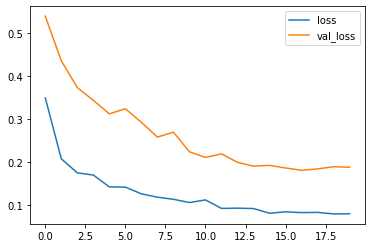

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

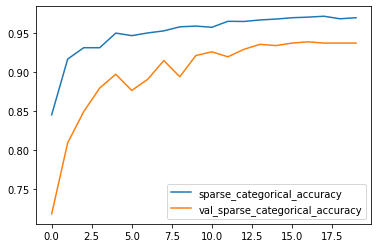

In [14]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.legend(['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])
plt.show()

## export model

In [15]:
MODEL_NAME = 'nasnet'

model.save('pneumonia-%s.h5' % (MODEL_NAME))

In [13]:
MODEL_NAME = 'nasnet'
tfjs.converters.save_keras_model(model, 'pneumonia-%s.tfjs' % (MODEL_NAME))

/home/kiddos/.local/lib/python3.6/site-packages/tensorflowjs/converters/keras_h5_conversion.py:122: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


AttributeError: 'Dataset' object has no attribute 'keys'